# Анализ бизнес-показателей сервиса Яндекс.Афиша

Исследование проведено для отдела маркетинга сервиса по продаже билетов на развлекательные мероприятия "Яндекс.Афиша" на основе данных за период с июня 2017 по май 2018 года включительно. Цель исследования — оценить эффективность маркетинговых кампаний и дать рекомендации по оптимизации рекламного бюджета.

1. [Изучение общей информации из файлов.](#step1)  
2. [Предобработка данных.](#step2)  
3. [Рассчет метрик.](#step3) 
4. [Выводы](#step4) 

## Изучение общей информации из файлов. <a id="step1"></a>    

### Получение данных

Импортируем библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

Прочитаем файлы и сохраним их в переменных.

In [2]:
visits = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

Объявим функцию *info()* для получения информации о данных и первых строк таблиц.

In [3]:
def info(data):
    data.info() 
    return data.head()

Изучим таблицу **visits**.

In [4]:
info(visits)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


**Таблица visits (лог сервера с информацией о посещениях сайта)**:
* Uid — уникальный идентификатор пользователя;
* Device — категория устройства пользователя;
* Start Ts — дата и время начала сессии;
* End Ts — дата и время окончания сессии;
* Source Id — идентификатор источника перехода на сайт.

Изучим таблицу **orders**.

In [5]:
info(orders)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


**Таблица orders (информация о заказах)**:
* Uid — уникальный идентификатор пользователя;
* Buy Ts — дата и время заказа;
* Revenue — сумма заказа.

Изучим таблицу **costs**.

In [6]:
info(costs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


**Таблица costs (информация о расходах на маркетинг)**:
* source_id —  идентификатор рекламного источника;
* dt — дата проведения рекламной кампании;
* costs — расходы на эту кампанию.

### Выводы

Каждая строка таблицы **visits** содержит информацию об отдельной сессии пользователя на сайте Яндекс.Афиша. Каждая строка таблицы **orders** содержит информацию об отдельном заказе пользователя на сайте. Каждая строка таблицы **costs** содержит информацию о расходах на отдельную рекламную кампанию. Проблемы, которые нужно решать: некачественные названия столбцов; строковый тип данных в столбце *dt* таблицы **costs**, в столбце *Buy Ts* таблицы **orders**, в столбцах *Start Ts*, *End Ts* таблицы **visits**.

## Предобработка данных. <a id="step2"></a> 

### Изменение названия столбцов

В названиях столбцов есть пробелы, заглавные буквы, которые могут затруднять доступ к данным. Переименуем столбцы для удобства дальнейшей работы. Проверим результат.

In [7]:
visits.columns = [col.lower().replace(' ','_') for col in visits.columns]

In [8]:
print(visits.columns)

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')


In [9]:
orders.columns = [col.lower().replace(' ','_') for col in orders.columns]

In [10]:
print(orders.columns)

Index(['buy_ts', 'revenue', 'uid'], dtype='object')


### Замена типа данных

Приведем значения в столбцах с датами к типу datetime.

In [11]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

### Проверка на наличие дубликатов

Проверим наличие дубликатов в таблицах методом .duplicated(). В сочетании с методом sum() он возвращает количество дубликатов. Если найдутся, удалим, и проверим, все ли удалились.

In [12]:
print(visits.duplicated().sum()) 

0


In [13]:
print(orders.duplicated().sum()) 

0


In [14]:
print(costs.duplicated().sum()) 

0


Дубликатов нет.

### Выводы

Мы изменили тип данных, где это было нужно и переимоновали столбцы для удобства дальнейшей работы. 

## Рассчет метрик. <a id="step3"></a> 

### Продуктовые метрики (как клиенты пользуются сервисом)

#### Рассчитаем DAU, WAU, MAU

**DAU** - количество уникальных пользователей в день. **WAU** - количество уникальных пользователей в неделю. **MAU** - количество уникальных пользователей в месяц.

Выделим в отдельные столбцы год, месяц, неделю, полную дату и дату (год, месяц, неделя) в формате *string*.

In [15]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].dt.month
visits['session_week'] = visits['start_ts'].dt.week
visits['session_date'] = visits['start_ts'].dt.date
visits['date_str_month'] = visits['start_ts'].dt.strftime('%Y-%m')
visits['date_str_week'] = visits['start_ts'].dt.strftime('%Y-%m-%U')
visits.head() 

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,date_str_month,date_str_week
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12,2017-12-51
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02,2018-02-07
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-07,2017-07-26
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,2018-05,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,2017-12,2017-12-52


Посчитаем метрики.

In [16]:
dau = visits.groupby(['session_year','session_date']).agg({'uid': 'nunique'}).reset_index()
dau_total = visits.groupby('session_date').agg({'uid': 'nunique'}).mean()
print(int(dau_total))

907


Среднее количество уникальных пользователей в день (**DAU**) - 907.

In [17]:
wau_total = visits.groupby(['session_year', 'session_week']).agg({'uid': 'nunique'}).mean()
print(int(wau_total))

5716


Среднее количество уникальных пользователей в неделю (**WAU**) - 5 716.

In [18]:
mau_total = visits.groupby(['session_year', 'session_month']).agg({'uid': 'nunique'}).mean()
print(int(mau_total))

23228


Среднее количество уникальных пользователей в месяц (**MAU**) - 23 228.

Отобразим изменения метрик во времени на графиках.

In [19]:
def lineplot(x_data, y_data, x_label='', y_label='', title=''):
    plt.style.use('seaborn-darkgrid')
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
    
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    
    plt.plot(x_data, y_data, color='orange', linewidth=2, alpha=0.7)
    plt.title(title)
    plt.show()

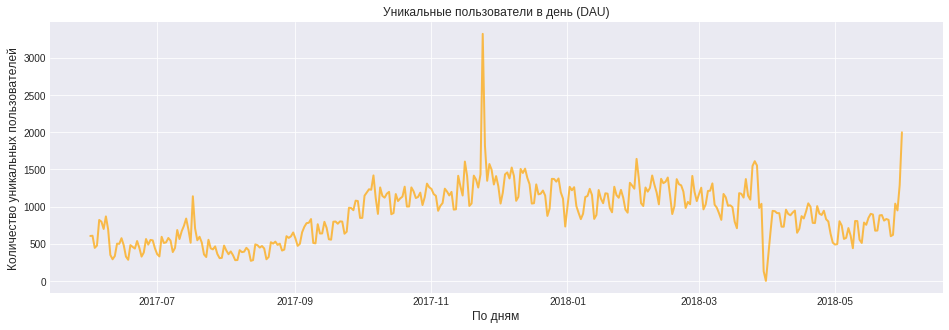

In [20]:
lineplot(dau['session_date'], dau['uid'], x_label='По дням',\
         y_label='Количество уникальных пользователей', \
         title='Уникальные пользователи в день (DAU)')

На графике есть дни с пиковой активностью: в конце ноября 2017г. (начале декабря 2017г.); в конце мая 2018 г. В конце марта был день с минимальным количеством активных пользователей, возможно это результат технического сбоя.

In [21]:
def barplot(x_data, y_data, x_label='', y_label='', title=''):
    plt.style.use('seaborn-darkgrid')
    fig, (ax) = plt.subplots(nrows=1, ncols=1, figsize=(16, 5))
    
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_xlabel(x_label, fontsize=12)
    
    plt.bar(x_data, y_data, color='orange', linewidth=1, alpha=0.5)
    plt.xticks(rotation=90)
    plt.title(title)
    plt.show()

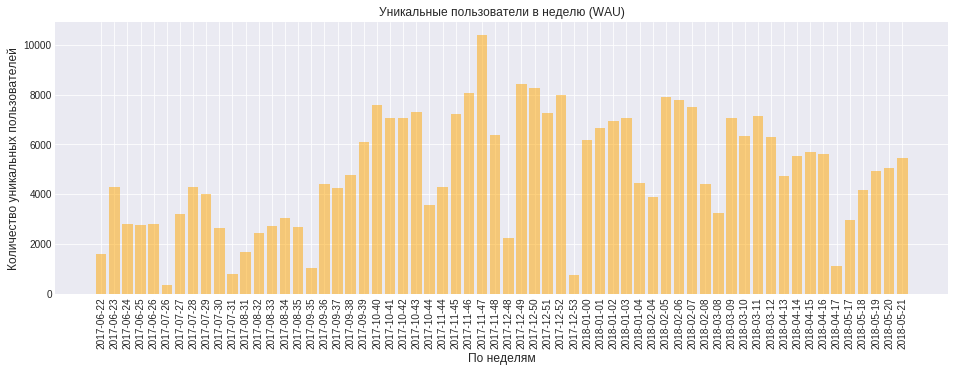

In [22]:
wau_during_time = visits.groupby(['date_str_week']).agg({'uid': 'nunique'}).reset_index()
barplot(wau_during_time['date_str_week'], wau_during_time['uid'], x_label='По неделям',\
         y_label='Количество уникальных пользователей', \
         title='Уникальные пользователи в неделю (WAU)')

Общая динамика графика WAU соответсвует динамике графика DAU.

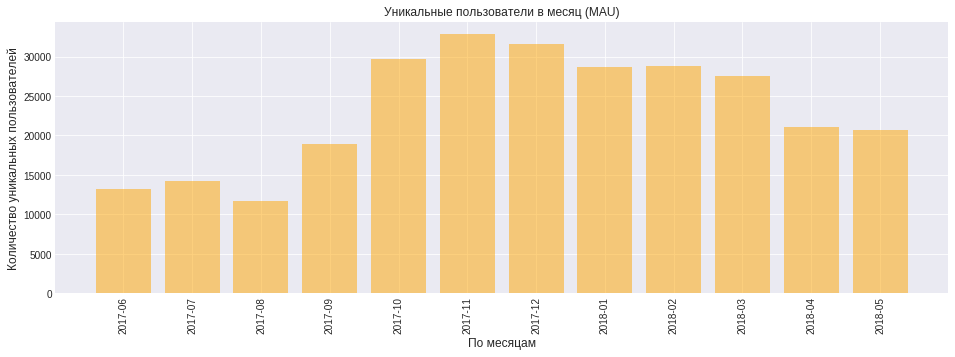

In [23]:
mau_during_time = visits.groupby(['date_str_month']).agg({'uid': 'nunique'}).reset_index()
barplot(mau_during_time['date_str_month'], mau_during_time['uid'], x_label='По месяцам',\
         y_label='Количество уникальных пользователей', \
         title='Уникальные пользователи в месяц (MAU)')

Общая динамика графика MAU соответсвует динамике графиков DAU, WAU.

#### Выводы

Среднее количество уникальных пользователей в день (**DAU**) - 907. Среднее количество уникальных пользователей в неделю (**WAU**) - 5 716. Среднее количество уникальных пользователей в месяц (**MAU**) - 23 228. По графикам видно, что количество уникальных пользователей возрастает в осенние месяцы, начиная с октября и держится на высоких показателях до марта включительно. Наибольшее число уникальных пользователей заходит на сайт в ноябре, декабре.

#### Рассчитаем среднее количество сессий за день на одного пользователя

Определим, сколько раз за день пользователи в среднем заходят на сайт. Построим график, отражающий изменения метрики во времени.

In [24]:
sessions_per_user = visits.groupby('session_date').agg({'uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sess_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user = sessions_per_user.reset_index()
sessions_per_user.head()

,session_date,n_sessions,n_users,sess_per_user
0,2017-06-01,664,605,1.097521
1,2017-06-02,658,608,1.082237
2,2017-06-03,477,445,1.071910
3,2017-06-04,510,476,1.071429
4,2017-06-05,893,820,1.089024


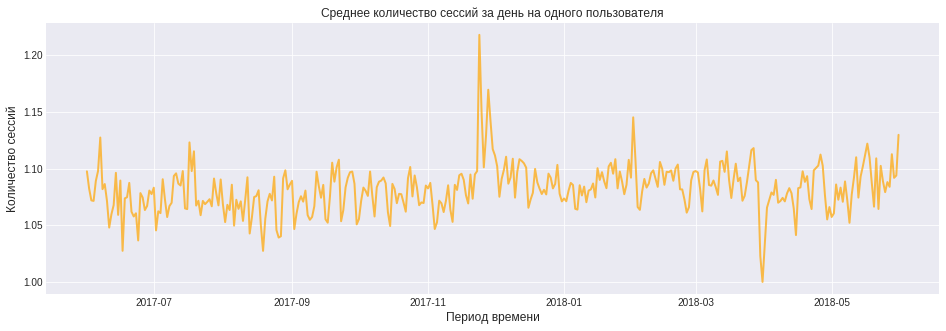

In [25]:
lineplot(sessions_per_user['session_date'], sessions_per_user['sess_per_user'], x_label='Период времени',\
         y_label='Количество сессий', \
         title='Среднее количество сессий за день на одного пользователя')

#### Выводы

В день один пользователь в среднем проводит на сайте 1 сессию. 

#### Рассчитаем среднюю продолжительность сессии (ASL) 

Средняя продолжительность сессии **(ASL)** показывает, сколько длится сессия пользователя в среднем.

In [26]:
visits['session_duration_sec'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Для понимания, что рассчитывать - среднее или моду, посмотрим на распределение.

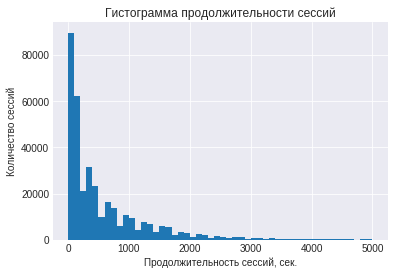

In [27]:
visits['session_duration_sec'].hist(bins=50, range=(0, 5000)) 
plt.title('Гистограмма продолжительности сессий')
plt.xlabel('Продолжительность сессий, сек.')
plt.ylabel('Количество сессий')
plt.show()

Судя по виду гистограммы распределения величины правильнее всего будет описать данное распределение модой (значение в выборке, которое встречается чаще всего).

In [28]:
print(visits['session_duration_sec'].mode()) 

0    60
dtype: int64


#### Выводы

Средняя продолжительность сессии пользователя - 60 секунд.

#### Рассчитаем Retention Rate

Рассчитаем **Retention Rate**, применяя когортный анализ. Построим график, отражающий изменения метрики во времени. 

**Retention Rate** показывает, сколько пользователей из когорты относительно их изначального числа вернулось в последующие периоды. Определим событие и период — на их основе сформируем когорту. Когортой станет месяц, в котором пользователь впервые зашел на сайт. 

Для каждого пользователя получим дату его первого посещения сайта.

In [29]:
first_activity_date = visits.groupby('uid')['start_ts'].min()
first_activity_date.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: start_ts, dtype: datetime64[ns]

В исходной таблице **visits** уже есть столбец *start_ts*. Изменим имя Series на first_activity_date, обратившись к атрибуту name у Series.

In [30]:
first_activity_date.name = 'first_activity_date'

In [31]:
visits = visits.join(first_activity_date, on='uid')

In [32]:
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,date_str_month,date_str_week,session_duration_sec,first_activity_date
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12,2017-12-51,1080,2017-12-20 17:20:00
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02,2018-02-07,1680,2018-02-19 16:53:00
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-07,2017-07-26,0,2017-07-01 01:54:00
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,2018-05,2018-05-20,1440,2018-03-09 20:05:00
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,2017-12,2017-12-52,0,2017-12-27 14:06:00


Выделим месяцы из даты первой сессии, месяцы дальнейших сессий.

In [33]:
visits['first_activity_month'] = visits['first_activity_date'].astype('datetime64[M]')
visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')

Найдём *lifetime* когорты. Из месяца посещения сайта *activity_month* вычтем месяц когорты *first_activity_month*.

In [34]:
visits['cohort_lifetime'] = (visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1, 'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')
visits.head()

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_date,date_str_month,date_str_week,session_duration_sec,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,12,51,2017-12-20,2017-12,2017-12-51,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2,8,2018-02-19,2018-02,2018-02-07,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,7,26,2017-07-01,2017-07,2017-07-26,0,2017-07-01 01:54:00,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,5,20,2018-05-20,2018-05,2018-05-20,1440,2018-03-09 20:05:00,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,12,52,2017-12-27,2017-12,2017-12-52,0,2017-12-27 14:06:00,2017-12-01,2017-12-01,0


Сгруппируем данные по когорте и *lifetime*. Посчитаем для каждой когорты количество активных пользователей на определённый «месяц жизни»:

In [35]:
cohort_visits = visits.groupby(['first_activity_month','cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
cohort_visits.head()

,first_activity_month,cohort_lifetime,uid
0,2017-06-01,0,13259
1,2017-06-01,1,1043
2,2017-06-01,2,713
3,2017-06-01,3,814
4,2017-06-01,4,909


Чтобы найти **Retention Rate**, нужно сперва получить число пользователей, изначально бывших в когорте, и на него разделить число пользователей в каждую следующую неделю. Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц.

In [36]:
initial_users_count = cohort_visits[cohort_visits['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'}) 
print(initial_users_count) 

   first_activity_month  cohort_users
0            2017-06-01         13259
12           2017-07-01         13140
23           2017-08-01         10181
33           2017-09-01         16704
42           2017-10-01         25977
50           2017-11-01         27248
57           2017-12-01         25268
63           2018-01-01         22624
68           2018-02-01         22197
72           2018-03-01         20589
75           2018-04-01         15709
77           2018-05-01         15273


Объединим данные по когортам с исходным количеством пользователей в когорте.

In [37]:
cohort_visits = cohort_visits.merge(initial_users_count,on='first_activity_month') 

Рассчитаем **Retention Rate**. Разделим количество активных пользователей в каждый месяц на исходное число пользователей в когорте.

In [38]:
cohort_visits['retention'] = cohort_visits['uid']/cohort_visits['cohort_users'] 
cohort_visits.head()

,first_activity_month,cohort_lifetime,uid,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775
3,2017-06-01,3,814,13259,0.061392
4,2017-06-01,4,909,13259,0.068557


In [39]:
cohort_visits['first_activity_month'] = cohort_visits['first_activity_month'].dt.strftime('%Y-%m')

In [40]:
retention_pivot = cohort_visits.pivot_table(index='first_activity_month', columns='cohort_lifetime',\
                                            values='retention',aggfunc='sum') 

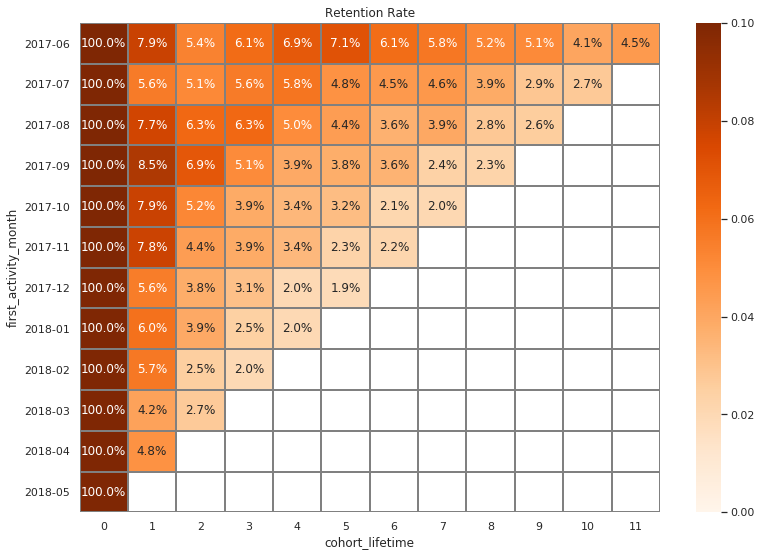

In [41]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention Rate')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.1, cmap = 'Oranges')

Найдем средний **Retention Rate** на второй месяц «жизни» когорт.

In [42]:
cohort_visits_per_month = cohort_visits[cohort_visits['cohort_lifetime'] == 1][['retention']]
cohort_visits_per_month_mean = cohort_visits_per_month['retention'].mean()
print('Средний Retention Rate на второй месяц "жизни" когорт {:.1%}.'.format(cohort_visits_per_month_mean)) 

Средний Retention Rate на второй месяц "жизни" когорт 6.5%.


#### Выводы

Самый низкий Retention Rate в первый месяц у когорт "2018-03", "2018-04": 4,2% и 4,8% соответственно. В когорте "2017-09" наиболее высокий коэффициент удержания в первый месяц: 8,5% потребителей вернулись повторно. В когорте "2017-06" Retention Rate убывает с течением времени медленее, чем в остальных когортах и не так равномерно: на 4 и 5 месяц коэффициент удержания возрастает. Средний Retention Rate на второй месяц "жизни" когорт 6.5%.

###  Метрики электронной коммерции

#### Рассчитаем, сколько времени в среднем проходит с момента посещения сайта до совершения покупки

Для каждого пользователя получим дату его первой покупки, первого визита.

In [43]:
first_buy = orders.groupby('uid').agg({'buy_ts':'min'}).reset_index()
first_buy.columns = ['uid', 'first_order']
first_visit = visits.groupby('uid').agg({'start_ts':'min'}).reset_index()
first_visit.columns = ['uid', 'first_visit']

Объеденим таблицы.

In [44]:
first_buy_data = first_buy.merge(first_visit, how='left')

Рассчитаем время между первой сессией и первым заказом.

In [45]:
first_buy_data['time_to_first_order'] = (first_buy_data['first_order'] - first_buy_data['first_visit']).dt.seconds

Для понимания, что рассчитывать - среднее или моду, посмотрим на распределение.

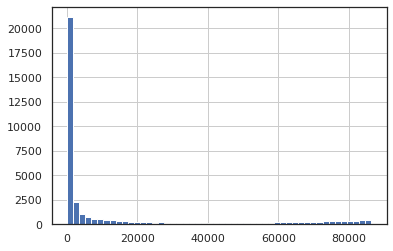

In [46]:
first_buy_data['time_to_first_order'].hist(bins=50)

Распределение не похоже на нормальное. Рассчитаем моду (значение в выборке, которое встречается чаще всего).

In [47]:
print(first_buy_data['time_to_first_order'].mode()) 

0    60
dtype: int64


#### Выводы

В среднем с момента посещения сайта до совершения покупки проходит 60 секунд.

#### Рассчитаем среднее количество покупок на одного покупателя

Применяя когортный анализ, рассчитаем среднее количество покупок на одного покупателя. Определим событие и период — на их основе сформируем когорту. Когортой станет месяц, в котором пользователь впервые совершил покупку. 

In [48]:
first_order_date = orders.groupby('uid')['buy_ts'].min()
first_order_date.name = 'first_order_date'
first_order_date.head()

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_order_date, dtype: datetime64[ns]

В исходной таблице **first_order** уже есть столбец *buy_ts*. Изменим имя Series на *first_order_date*, обратившись к атрибуту name у Series.

In [49]:
first_order = orders.join(first_order_date, on='uid')

Выделим месяцы из даты первой покупки, месяцы дальнейших покупок.

In [50]:
first_order['first_order_month'] = first_order['first_order_date'].astype('datetime64[M]')
first_order['order_month'] = first_order['buy_ts'].astype('datetime64[M]')
first_order.head()

,buy_ts,revenue,uid,first_order_date,first_order_month,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01


Посчитаем количество новых покупателей за каждый месяц (количество людей в когорте):

In [51]:
cohort_sizes = first_order.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


Посчитаем суммарное количество покупок одной когорты по месяцам.

In [52]:
cohorts_orders = first_order.groupby(['first_order_month', 'order_month']).agg({'uid': 'count'}).reset_index()
cohorts_orders.columns = ['first_order_month', 'order_month', 'order_sum']
cohorts_orders.head()

,first_order_month,order_month,order_sum
0,2017-06-01,2017-06-01,2354
1,2017-06-01,2017-07-01,177
2,2017-06-01,2017-08-01,174
3,2017-06-01,2017-09-01,226
4,2017-06-01,2017-10-01,292


Соединим таблицу с количеством пользователей в когорте и таблицу с сумарным количеством покупок.

In [53]:
cohorts_orders_sum = cohorts_orders.merge(cohort_sizes, on = 'first_order_month')
cohorts_orders_sum.head()

,first_order_month,order_month,order_sum,n_buyers
0,2017-06-01,2017-06-01,2354,2023
1,2017-06-01,2017-07-01,177,2023
2,2017-06-01,2017-08-01,174,2023
3,2017-06-01,2017-09-01,226,2023
4,2017-06-01,2017-10-01,292,2023


Найдём *lifetime* когорты. Из месяца покупки *order_month* вычтем месяц когорты *first_order_month*.

In [54]:
cohorts_orders_sum['orders_lifetime'] = cohorts_orders_sum['order_month'] - cohorts_orders_sum['first_order_month']
cohorts_orders_sum['orders_lifetime'].head() 

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: orders_lifetime, dtype: timedelta64[ns]

In [55]:
cohorts_orders_sum['orders_lifetime'] = cohorts_orders_sum['orders_lifetime'] / np.timedelta64(1, 'M')
cohorts_orders_sum['orders_lifetime'] = cohorts_orders_sum['orders_lifetime'].round().astype('int')
cohorts_orders_sum.head()

,first_order_month,order_month,order_sum,n_buyers,orders_lifetime
0,2017-06-01,2017-06-01,2354,2023,0
1,2017-06-01,2017-07-01,177,2023,1
2,2017-06-01,2017-08-01,174,2023,2
3,2017-06-01,2017-09-01,226,2023,3
4,2017-06-01,2017-10-01,292,2023,4


Разделим количество заказов когорт за каждый месяц на общее число пользователей в каждой когорте. 

In [56]:
cohorts_orders_sum['orders_per_buyer'] = cohorts_orders_sum['order_sum'] / cohorts_orders_sum['n_buyers']
cohorts_orders_sum.head()

,first_order_month,order_month,order_sum,n_buyers,orders_lifetime,orders_per_buyer
0,2017-06-01,2017-06-01,2354,2023,0,1.163618
1,2017-06-01,2017-07-01,177,2023,1,0.087494
2,2017-06-01,2017-08-01,174,2023,2,0.086011
3,2017-06-01,2017-09-01,226,2023,3,0.111715
4,2017-06-01,2017-10-01,292,2023,4,0.144340


In [57]:
cohorts_orders_sum_pivot = cohorts_orders_sum.pivot_table(index='first_order_month', columns='orders_lifetime',\
                                                          values='orders_per_buyer', aggfunc='mean').round(2)
cohorts_orders_sum_pivot = cohorts_orders_sum_pivot.cumsum(axis=1)
cohorts_orders_sum_pivot.fillna('') 

orders_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,1.16,1.25,1.34,1.45,1.59,1.7,1.84,1.93,2.03,2.11,2.16,2.2
2017-07-01,1.14,1.19,1.25,1.3,1.34,1.38,1.41,1.44,1.47,1.48,1.51,
2017-08-01,1.12,1.2,1.27,1.33,1.39,1.44,1.48,1.54,1.57,1.6,,
2017-09-01,1.14,1.22,1.28,1.34,1.37,1.41,1.45,1.47,1.49,,,
2017-10-01,1.14,1.21,1.25,1.28,1.31,1.33,1.35,1.38,,,,
2017-11-01,1.18,1.28,1.32,1.37,1.4,1.41,1.43,,,,,
2017-12-01,1.15,1.21,1.26,1.3,1.32,1.34,,,,,,
2018-01-01,1.12,1.19,1.24,1.26,1.28,,,,,,,
2018-02-01,1.12,1.18,1.2,1.22,,,,,,,,


Рассчитаем среднее количество покупок на одного покупателя за 6-ой месяц "жизни" когорты.

In [58]:
print('Среднее количество покупок на одного пользователя за 6-ой месяц "жизни" когорты: {:.2f}'\
.format(cohorts_orders_sum_pivot.mean()[5]))

Среднее количество покупок на одного пользователя за 6-ой месяц "жизни" когорты: 1.43


#### Выводы

Количество покупок на пользователя в первый месяц "жизни" когорты превышает единицу (кроме когорты "2018-06-01", где этот показатель равен 1). Среди всех когорт налучшие результы у когорты "2017-06". Среднее количество покупок на одного пользователя за 6-ой месяц - 1.43.

#### Рассчитаем средний чек

In [59]:
revenue = first_order.groupby('order_month').agg({'revenue':'mean'}).reset_index()
revenue.head()

,order_month,revenue
0,2017-06-01,4.060106
1,2017-07-01,5.306589
2,2017-08-01,4.847139
3,2017-09-01,5.416448
4,2017-10-01,4.928280


In [117]:
print('Средний чек пользователя:', first_order['revenue'].mean(), 'у.е.')

Средний чек пользователя: 4.999646930477041 у.е.


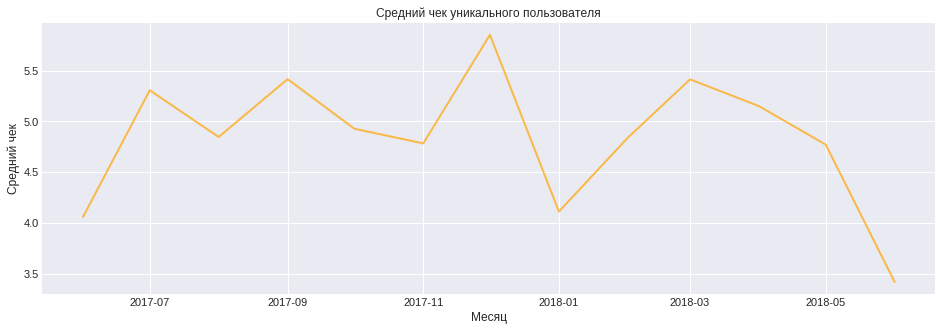

In [62]:
lineplot(revenue['order_month'], revenue['revenue'], x_label='Месяц',\
         y_label='Средний чек', \
         title='Средний чек уникального пользователя')

#### Выводы

Средний чек пользователя - 5.0 у.е. Есть некая сезонность у этого показателя: средний чек сильно возрастает в сентябре, декабре, марте. Возможно, это связано с сезонными праздниками.

#### Рассчитаем LTV на покупателя по когортам

**LTV** - "пожизненная ценность клиента", итоговая сумма денег, которую один клиент приносит в среднем со всех покупок.

Посчитаем суммарное количество выручки одной когорты по месяцам.

In [63]:
cohorts_revenue = first_order.groupby(['first_order_month','order_month'])['revenue'].sum().reset_index()
cohorts_revenue.columns = ['first_order_month', 'order_month', 'revenue_sum']
cohorts_revenue.head()

,first_order_month,order_month,revenue_sum
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


Объединим таблицы **cohorts_revenue** и **cohort_sizes**.

In [64]:
cohorts_revenue_sum = cohorts_revenue.merge(cohort_sizes, on ='first_order_month')
cohorts_revenue_sum.head()

,first_order_month,order_month,revenue_sum,n_buyers
0,2017-06-01,2017-06-01,9557.49,2023
1,2017-06-01,2017-07-01,981.82,2023
2,2017-06-01,2017-08-01,885.34,2023
3,2017-06-01,2017-09-01,1931.30,2023
4,2017-06-01,2017-10-01,2068.58,2023


Найдём *lifetime* когорты. Из месяца покупки *order_month* вычтем месяц когорты *first_order_month*.

In [65]:
cohorts_revenue_sum['revenue_lifetime'] = cohorts_revenue_sum['order_month'] - cohorts_revenue_sum['first_order_month']
cohorts_revenue_sum['revenue_lifetime'].head() 

0     0 days
1    30 days
2    61 days
3    92 days
4   122 days
Name: revenue_lifetime, dtype: timedelta64[ns]

In [66]:
cohorts_revenue_sum['revenue_lifetime'] = cohorts_revenue_sum['revenue_lifetime'] / np.timedelta64(1, 'M')
cohorts_revenue_sum['revenue_lifetime'] = cohorts_revenue_sum['revenue_lifetime'].round().astype('int')
cohorts_revenue_sum.head()

,first_order_month,order_month,revenue_sum,n_buyers,revenue_lifetime
0,2017-06-01,2017-06-01,9557.49,2023,0
1,2017-06-01,2017-07-01,981.82,2023,1
2,2017-06-01,2017-08-01,885.34,2023,2
3,2017-06-01,2017-09-01,1931.30,2023,3
4,2017-06-01,2017-10-01,2068.58,2023,4


Найдем валовую прибыль, умножив выручку на маржинальность (100%).

In [67]:
margin_rate = 1
cohorts_revenue_sum['gp'] = cohorts_revenue_sum['revenue_sum'] * margin_rate
cohorts_revenue_sum.head()

,first_order_month,order_month,revenue_sum,n_buyers,revenue_lifetime,gp
0,2017-06-01,2017-06-01,9557.49,2023,0,9557.49
1,2017-06-01,2017-07-01,981.82,2023,1,981.82
2,2017-06-01,2017-08-01,885.34,2023,2,885.34
3,2017-06-01,2017-09-01,1931.30,2023,3,1931.30
4,2017-06-01,2017-10-01,2068.58,2023,4,2068.58


Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте. Найдем накопительный LTV.

In [68]:
cohorts_revenue_sum['first_order_month'] = cohorts_revenue_sum['first_order_month'].dt.strftime('%Y-%m')

In [69]:
cohorts_revenue_sum['ltv'] = cohorts_revenue_sum['gp'] / cohorts_revenue_sum['n_buyers']
cohorts_revenue_sum_pivot = cohorts_revenue_sum.pivot_table(index='first_order_month',\
                                                            columns='revenue_lifetime', values='ltv', aggfunc='mean')

ltv = cohorts_revenue_sum_pivot.cumsum(axis=1)

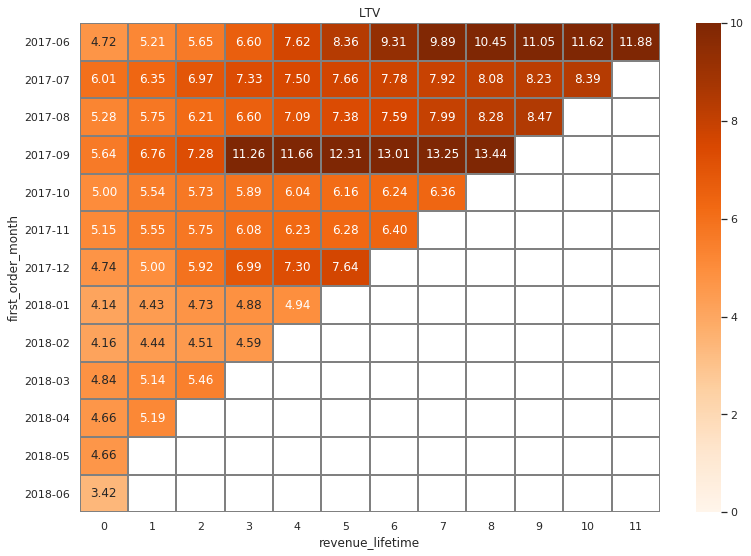

In [70]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=10, cmap = 'Oranges')

In [71]:
print('Средний LTV на 6-ой месяц: {:.2f}'.format(ltv.mean()[5]), 'у.е.')

Средний LTV на 6-ой месяц: 7.97 у.е.


#### Выводы

Один клиент приносит в среднем со всех своих покупок за 6 месяцев "жизни" когорты 7.97 у.е. Когорты с самым большим коэффициентом LTV: "2017-06", "2017-09". Пользователей этих когорт можно назвать лояльными (это клиенты с самым большим средним чеком, либо клиенты, которые часто совершают покупки). 

###  Маркетинговые метрики

#### Рассчитаем общую стоимость маркетинга

Посчитаем общую сумму на маркетинг.

In [72]:
print("Общая стоимость маркетинга:", costs['costs'].sum())

Общая стоимость маркетинга: 329131.62


Выясним, как траты распределены по источникам. 

In [73]:
costs_per_source = costs.groupby('source_id')['costs'].sum().reset_index()
costs_per_source.head(7)

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [74]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [75]:
costs['costs_month'] = costs['dt'].astype('datetime64[M]')
costs['costs_month'] = costs['costs_month'].dt.strftime('%Y-%m')

In [76]:
costs_cohorts = costs.pivot_table(index='costs_month',columns='source_id',values='costs',aggfunc='sum').round(1)

Text(0, 0.5, 'Сумма расходов')

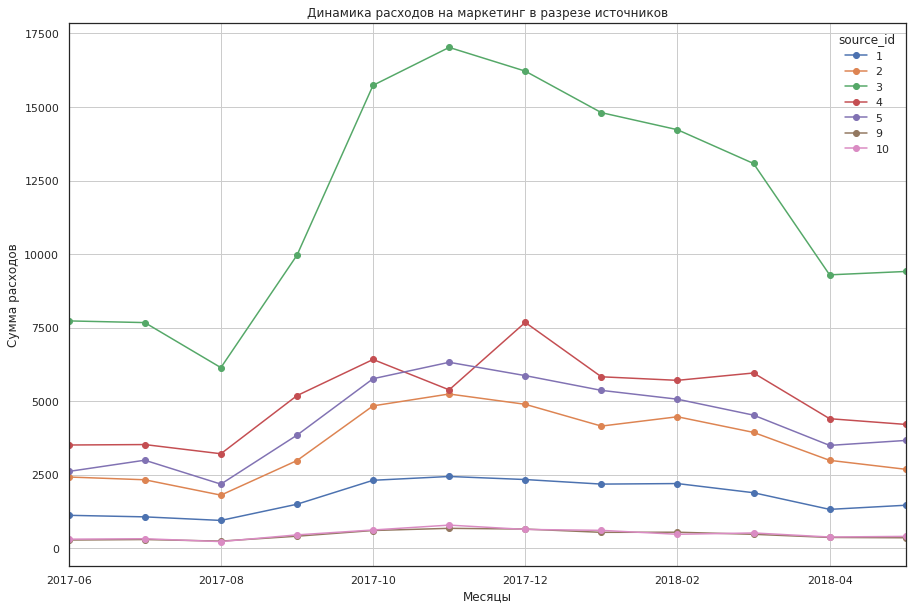

In [77]:
costs_cohorts.plot(grid=True, figsize=(15, 10), style='o-')
plt.title('Динамика расходов на маркетинг в разрезе источников')
plt.xlabel('Месяцы')
plt.ylabel('Сумма расходов')

#### Выводы

Расходы на маркетинговую компанию по источнику 3 наибольшие (141 321.63 у.е), по источнику 9 - наименьшие (5 822.49 у.е.). По графику видно, что траты по времени распределены неравномерно. На источник 3 тратится значительная часть бюджета - в каждый из месяцев больше, чем по любому другому. Расход по нему резко растет с сентября по ноябрь. По источнику 4 расход меняется относительно резко. В ноябре в противоположность остальным источникам затраты по нему были снижены. Остальные источники имеют более плавную динамику расходов с ростом к ноябрю-декабрю и последующим сниженим.

#### Рассчитаем средний CAC

**CAC** — стоимость привлечения клиента. Сумма денег, во сколько обходится новый клиент компании.

Рассчитаем средний **CAC** на одного покупателя для всего проекта.

Найдём суммарные расходы за каждый месяц.

In [78]:
costs['month'] = costs['dt'].astype('datetime64[M]') 
monthly_costs = costs.groupby('month')['costs'].sum().reset_index()

In [79]:
monthly_costs.columns = ['first_order_month','monthly_costs']
monthly_costs.head() 

,first_order_month,monthly_costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88


Выведем размер когорты.

In [80]:
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [81]:
report = cohort_sizes.merge(monthly_costs, on = 'first_order_month')
report.head()

,first_order_month,n_buyers,monthly_costs
0,2017-06-01,2023,18015.00
1,2017-07-01,1923,18240.59
2,2017-08-01,1370,14790.54
3,2017-09-01,2581,24368.91
4,2017-10-01,4340,36322.88


Поделим расходы за месяц на количетсво людей в когорте.

In [82]:
report['cac'] = report['monthly_costs'] / report['n_buyers']
report.head() 

,first_order_month,n_buyers,monthly_costs,cac
0,2017-06-01,2023,18015.00,8.905091
1,2017-07-01,1923,18240.59,9.485486
2,2017-08-01,1370,14790.54,10.796015
3,2017-09-01,2581,24368.91,9.441654
4,2017-10-01,4340,36322.88,8.369327


In [83]:
cac_mean = report['cac'].mean()
print('Cредний CAC на одного покупателя для всего проекта', cac_mean.round(2), 'у.е.')

Cредний CAC на одного покупателя для всего проекта 9.15 у.е.


Рассчитаем средний **CAC** на одного покупателя для каждого источника трафика.

Выясним, как траты распределены по источникам в когортах.

In [84]:
costs_sum_source = costs.groupby(['month','source_id']).agg({'costs': 'sum'}).reset_index()
costs_sum_source.head()

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12


Расчет будем вести по людям, которые сделали хотя бы один заказ. Найдем главный источник - источник, с котрого пользователь пришел в самый первый раз.

In [85]:
first_source = visits.sort_values(by=(['uid', 'start_ts'])).groupby(['uid'])['source_id'].first()
first_source.name = 'first_source'
first_source.head()

uid
11863502262781     3
49537067089222     2
297729379853735    3
313578113262317    2
325320750514679    5
Name: first_source, dtype: int64

In [86]:
orders.head()

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


Добавляем первый источник, из которого пришел пользователь, в таблицу заказов.

In [87]:
first_orders = orders.groupby('uid')['buy_ts'].min().reset_index()
first_orders['order_month'] = first_orders['buy_ts'].astype('datetime64[M]')
first_orders.head()

,uid,buy_ts,order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-01
2,2429014661409475,2017-10-11 18:33:00,2017-10-01
3,2464366381792757,2018-01-28 15:54:00,2018-01-01
4,2551852515556206,2017-11-24 10:14:00,2017-11-01


Объеденим таблицы.

In [88]:
first_orders = first_orders.join(first_source, on='uid')

In [89]:
first_orders.head()

,uid,buy_ts,order_month,first_source
0,313578113262317,2018-01-03 21:51:00,2018-01-01,2
1,1575281904278712,2017-06-03 10:13:00,2017-06-01,10
2,2429014661409475,2017-10-11 18:33:00,2017-10-01,3
3,2464366381792757,2018-01-28 15:54:00,2018-01-01,5
4,2551852515556206,2017-11-24 10:14:00,2017-11-01,5


Найдем количество пользователей, которые совершили покупку, группируя по разным источникам.

In [90]:
users_source = first_orders.groupby(['order_month','first_source']).agg({'uid':'count'}).reset_index()

In [91]:
users_source.head()

,order_month,first_source,uid
0,2017-06-01,1,190
1,2017-06-01,2,235
2,2017-06-01,3,638
3,2017-06-01,4,413
4,2017-06-01,5,384


Объединим таблицы, посчитаем **CAC**.

In [92]:
report_new = costs_sum_source.merge(users_source, left_on=['month', 'source_id'], \
                                    right_on=['order_month', 'first_source'])

In [93]:
report_new.head()

,month,source_id,costs,order_month,first_source,uid
0,2017-06-01,1,1125.61,2017-06-01,1,190
1,2017-06-01,2,2427.38,2017-06-01,2,235
2,2017-06-01,3,7731.65,2017-06-01,3,638
3,2017-06-01,4,3514.80,2017-06-01,4,413
4,2017-06-01,5,2616.12,2017-06-01,5,384


In [94]:
report_new['cac'] = report_new['costs'] / report_new['uid']

In [95]:
report_new.head()

,month,source_id,costs,order_month,first_source,uid,cac
0,2017-06-01,1,1125.61,2017-06-01,1,190,5.924263
1,2017-06-01,2,2427.38,2017-06-01,2,235,10.329277
2,2017-06-01,3,7731.65,2017-06-01,3,638,12.118574
3,2017-06-01,4,3514.80,2017-06-01,4,413,8.510412
4,2017-06-01,5,2616.12,2017-06-01,5,384,6.812813


In [96]:
cac = report_new.groupby('first_source')['cac'].mean().reset_index()

In [97]:
print(cac)

   first_source        cac
0             1   7.212107
1             2  12.504068
2             3  13.802743
3             4   6.439374
4             5   7.451938
5             9   5.413892
6            10   4.867125


In [98]:
cac_pivot = report_new.pivot_table(index='month', columns='source_id', values='cac', aggfunc='mean')

Text(0, 0.5, 'Источники')

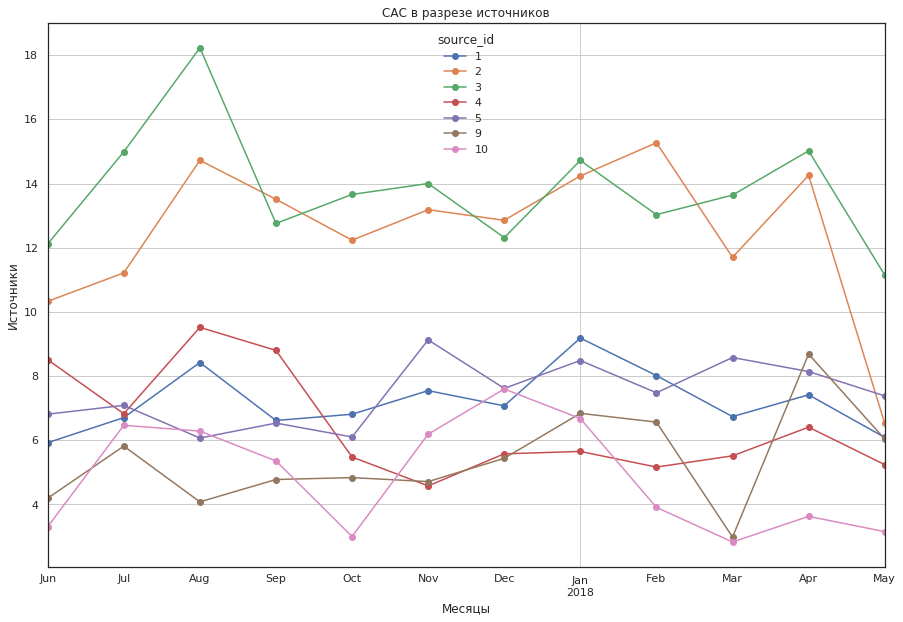

In [99]:
cac_pivot.plot(grid=True, figsize=(15, 10), style='o-')
plt.title('CAC в разрезе источников')
plt.xlabel('Месяцы')
plt.ylabel('Источники')

#### Выводы

**CAC** по источникам различается. Наибольшая стоимость клиента по источникам 2 и 3. Остальные источники приводят клиентов по меньшей цене. Динамика по каждому источнику своя.

#### Рассчитайте ROMI по когортам в разрезе источников

In [100]:
first_orders.sample()

,uid,buy_ts,order_month,first_source
25022,12633648685448621379,2017-09-30 21:17:00,2017-09-01,5


In [101]:
orders.sample()

,buy_ts,revenue,uid
43177,2018-04-05 13:14:00,11.92,16207804836754059428


In [102]:
orders['date'] = orders['buy_ts'].astype('datetime64[D]')
first_order_date = orders.groupby('uid')['date'].min()
first_order_date.name = 'first_order_date'
orders = orders.join(first_order_date, on='uid')

orders.head()

,buy_ts,revenue,uid,date,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01


In [103]:
orders['lifetime'] = orders['date'] - orders['first_order_date']
orders['lifetime'] = orders['lifetime'] / np.timedelta64(1, 'M')
orders['lifetime'] = orders['lifetime'].round().astype('int')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders.head()

,buy_ts,revenue,uid,date,first_order_date,lifetime,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0,2017-06-01


Объединим нужные таблицы для работы.

In [104]:
final = first_orders.merge(orders, on = ('uid'))
final.head()

,uid,buy_ts_x,order_month,first_source,buy_ts_y,revenue,date,first_order_date,lifetime,first_order_month
0,313578113262317,2018-01-03 21:51:00,2018-01-01,2,2018-01-03 21:51:00,0.55,2018-01-03,2018-01-03,0,2018-01-01
1,1575281904278712,2017-06-03 10:13:00,2017-06-01,10,2017-06-03 10:13:00,1.22,2017-06-03,2017-06-03,0,2017-06-01
2,1575281904278712,2017-06-03 10:13:00,2017-06-01,10,2017-06-03 17:39:00,1.83,2017-06-03,2017-06-03,0,2017-06-01
3,2429014661409475,2017-10-11 18:33:00,2017-10-01,3,2017-10-11 18:33:00,73.33,2017-10-11,2017-10-11,0,2017-10-01
4,2464366381792757,2018-01-28 15:54:00,2018-01-01,5,2018-01-28 15:54:00,2.44,2018-01-28,2018-01-28,0,2018-01-01


Считаем выручку заказов по месяцу первого заказа, lifetime и источнику.

In [105]:
roi = final.groupby(['first_order_month','lifetime','first_source'])['revenue'].sum().reset_index()

In [106]:
roi.columns = ['month','cohort_lifetime','source_id','revenue']

Объединяем данные по выручке с таблицей *report_new* по месяцу и источнику.

In [107]:
roi = roi.merge(report_new, on=('month','source_id'))
roi.head()

,month,cohort_lifetime,source_id,revenue,costs,order_month,first_source,uid,cac
0,2017-06-01,0,1,1360.87,1125.61,2017-06-01,1,190,5.924263
1,2017-06-01,1,1,328.40,1125.61,2017-06-01,1,190,5.924263
2,2017-06-01,2,1,284.46,1125.61,2017-06-01,1,190,5.924263
3,2017-06-01,3,1,668.33,1125.61,2017-06-01,1,190,5.924263
4,2017-06-01,4,1,893.11,1125.61,2017-06-01,1,190,5.924263


Считаем метрики - **LTV** и **ROI**.

In [108]:
roi['ltv'] = roi['revenue'] / roi['uid']
roi['roi'] = roi['ltv'] / roi['cac']

In [109]:
roi['month'] = roi['month'].dt.strftime('%Y-%m')

Строим сводную таблицу когортного анализа по среднему LTV и визуализируем.

In [110]:
ltv_source_pivot = roi.pivot_table(index='source_id', columns='cohort_lifetime', values='ltv', aggfunc='mean')

Text(120.5, 0.5, 'Источники')

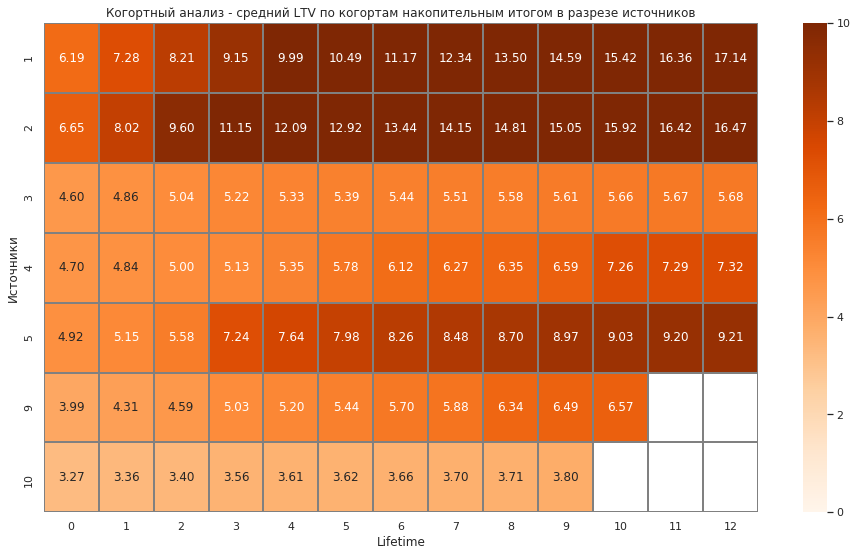

In [111]:
plt.figure(figsize=(16,9))

sns.heatmap(ltv_source_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray',\
            vmin=0, vmax=10, cmap = 'Oranges')
plt.title('Когортный анализ - средний LTV по когортам накопительным итогом в разрезе источников')
plt.xlabel('Lifetime')
plt.ylabel('Источники')

Наибольший **LTV** по источникам 1 и 2 к 12 месяцу более 16 у.е. Далее существенный **LTV** в порядке убывания дают 5, 4 и 9 источники. **LTV** источника 3 растет очень медленными темпами. Источник 10 имеет наименьший **LTV**, который со временем почти не растет.

Строим сводную таблицу когортного анализа по среднему **ROI** и визуализируем.

In [112]:
roi_pivot = roi.pivot_table(index='source_id', columns='cohort_lifetime', values='roi', aggfunc='mean')

Text(120.5, 0.5, 'Источники')

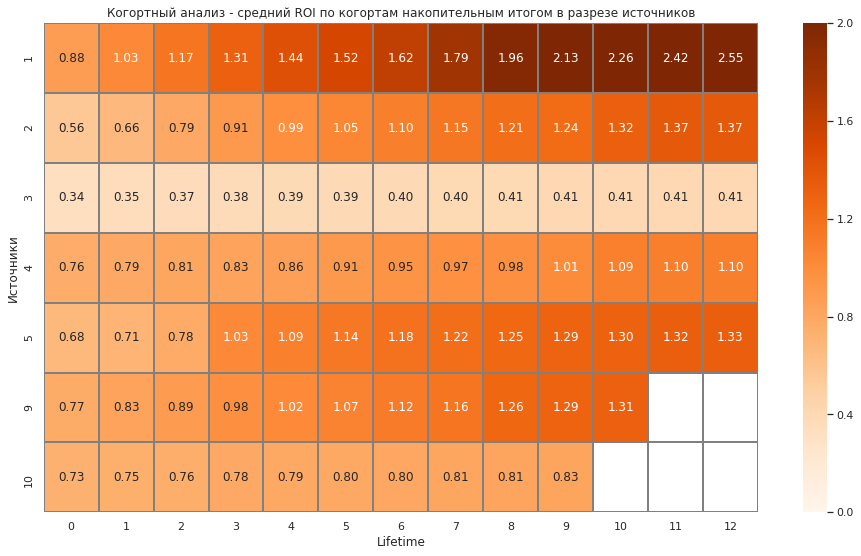

In [113]:
plt.figure(figsize=(16,9))

sns.heatmap(roi_pivot.cumsum(axis=1), annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=2, cmap = 'Oranges')
plt.title('Когортный анализ - средний ROI по когортам накопительным итогом в разрезе источников')
plt.xlabel('Lifetime')
plt.ylabel('Источники')

- Клиенты источника 1 окупаются быстрее всех остальных - уже на второй месяц. При этом **ROI** продолжает расти, достигая к 12 месяцу более 250%.
- Источники 2, 5 и 9 окупаются примерно одинакого - на 4-5-ый месяцы. После месяца, когда расходы окупились, **ROI** продолжает расти. 
- Источник 4 медленно, но окупается на 10-ый месяц жизни когорт.
- Источник 10 отбивает значительную часть расходов в 1-ый месяц, но далее **ROI** почти не растет. Судя по динамике, либо расходы по нему не окупятся вообще, либо это займет годы.
- Источник 3 в 1-ый и последующие месяцы отбивает меньше расходов, чем любой другой. Отстуствие существенной положительной динамики по **ROI** говорит о том, что он не окупится.

## Выводы. <a id="step4"></a> 

Сайт Яндекс.Афиша посещают в среднем в день - 907 раз, в неделю - 5 716, в месяц  - 23 228 раз. По графикам видно, что количество уникальных пользователей возрастает в осенние месяцы, начиная с октября и держится на высоких показателях до марта включительно. Наибольшее число уникальных пользователей заходит на сайт в ноябре, декабре. Посещаемость сайта с 2017 года выросла.

В среднем пользователь посещает сайт 1 раз в день с длительностью 60 секунд. Количество покупок на пользователя в первый месяц "жизни" когорты превышает единицу (кроме когорты "2018-06-01", где этот показатель равен 1).

Средний Retention Rate на второй месяц "жизни" когорт 6.5%. Самый низкий Retention Rate в первый месяц у когорт "2018-03", "2018-04": 4,2% и 4,8% соответственно. В когорте "2017-09" наиболее высокий коэффициент удержания в первый месяц: 8,5% потребителей вернулись повторно. В когорте "2017-06" Retention Rate убывает с течением времени медленее, чем в остальных когортах и не так равномерно: на 4 и 5 месяц коэффициент удержания возрастает. 

- **Источник 1.** Наиболее ценный источник. Имеет наибольший LTV и приемлемый САС. Расходы по нему окупаются уже на второй месяц.

  **Рекомендация:** Если возможно - масштабировать + увеличить бюджет, если нет - оставить все, как есть.
  
  
- **Источник 2.** Ценный источник. Высокий САС, но имет один из наибольших LTV (2 место). Расходы окупаютя на 5-6 месяц. 
  
  **Рекомендация:** Снизить САС + масштабировать + увеличить бюджет.


- **Источник 3.** Имеет наибольшую долю в расходах маркетинг и наибольший САС. LTV растет медленно (6 место) и уступает большинству других источников. Отстуствие существенной положительной динамики по ROI в когортном анализе говорит о том, что расходы по нему не окупятся.
  
  **Рекомендация:** Сильно снизить САС + уменьшить бюджет.


- **Источник 4.** Имеет приемлемый САС, хороший LTV (4 место). Расходы по нему окупаются медленно - на 10-ый месяц.
  
  **Рекомендация:** Снизить САС + бюджет оставить на текущем уровне.


- **Источник 5.** Имеет приемлемый САС, хороший LTV (3 место). Расходы по нему окупаются на 4-ый месяц.
  
  **Рекомендация:** Масштабировать + увеличить бюджет.


- **Источник 9.** Имеет приемлемый САС, хороший LTV (5 место). Расходы по нему окупаются на 4-5-ый месяц.
  
  **Рекомендация:** Масштабировать + увеличить бюджет.


- **Источник 10.** Имеет приемлемый САС, но наименьший LTV (7 место). Расходы по нему либо не окупятся, либо будут окупаться очень долго.
  **Рекомендация:** Уменьшить бюджет.